In [ ]:
pip install git+https://github.com/TIA-Lab/tiatoolbox.git@feature-model-segmentation


In [1]:
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150 # for high resolution figure in notebook

from tiatoolbox.wsicore.wsireader import get_wsireader
from tiatoolbox.utils.visualisation import visualize_instances_dict
from tiatoolbox.utils.misc import download_data, imread
from tiatoolbox.models.segmentation import NucleiInstanceSegmentor, SemanticSegmentor

# Nuclei Instance Segmentation

In [2]:
predictor = NucleiInstanceSegmentor(
                pretrained_model='hovernet-pannuke', 
                pretrained_weight='/home/tialab-dang/local/project/tiatoolbox/tests/pretrained/pannuke.pth')

## Predicting on Image Tiles

In [3]:
sample_url = ("https://tiatoolbox.dcs.warwick.ac.uk/testdata/"
                   "patchextraction/TCGA-HE-7130-01Z-00-DX1.png")
sample_path = 'sample_tile.png'
download_data(sample_url, sample_path)
sample = imread(sample_path)
print(sample.shape)

Download from https://tiatoolbox.dcs.warwick.ac.uk/testdata/patchextraction/TCGA-HE-7130-01Z-00-DX1.png
Save to sample_tile.png
(1000, 1000, 3)


Image tile will be treated as a pseudo WSI but with only baseline level and containing no mpp information. Hence, we must request the model to predict at `resolution=1.0` and `units='baseline'`.

In [4]:
output = predictor.predict([sample_path], [None], mode='tile', 
                        resolution=1.0, units='baseline', on_gpu=True)

|2021-05-18|14:27:23.941| [WARNING] ../tiatoolbox/wsicore/wsimeta.py:155: UserWarning: Raw data is None
  warnings.warn("Raw data is None")

|2021-05-18|14:27:23.943| [WARNING] ../tiatoolbox/wsicore/wsimeta.py:158: UserWarning: Unknown scale (no objective_power or mpp)
  warnings.warn("Unknown scale (no objective_power or mpp)")


Fwrd-Tile:   0%|                                          | 0/1 [00:00<?, ?it/s]

Fwrd-Btch:   0%|                                          | 0/7 [00:00<?, ?it/s]|2021-05-18|14:27:24.054| [WARNING] /home/tialab-dang/anaconda3/envs/py37-df/lib/python3.7/site-packages/torch/utils/data/_utils/collate.py:63: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the re

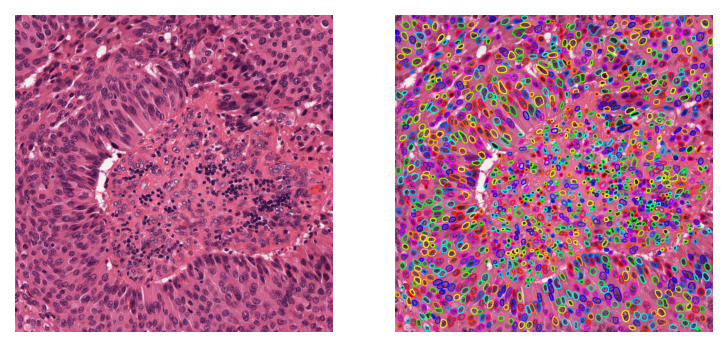

In [5]:
overlay = visualize_instances_dict(sample, output, line_thickness=2)

plt.subplot(1,2,1)
plt.imshow(sample)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.axis('off')
plt.show()

Prediction on WSI can be done in the same way, however, we can change the read resolution to any other units. For this example, we read the WSI at mpp=0.25 (or 40x so to speak) with arguments `resolution=0.25`, `units='mpp'`. This is also the resolution which the `hovernet-pannuke` model was pretrained on.

In [6]:
# sample_url = ("https://tiatoolbox.dcs.warwick.ac.uk/testdata/models/CMU-mini.svs")
# sample_path = 'sample_wsi.svs'
# download_data(sample_url, sample_path)
sample_path = '/home/tialab-dang/local/project/tiatoolbox/tests/data/CMU-mini_002.svs'
sample_mask_path = '/home/tialab-dang/local/project/tiatoolbox/tests/data/CMU-mini_002-mask.png'
output = predictor.predict([sample_path], [sample_mask_path], mode='wsi', 
                        resolution=0.25, units='mpp', on_gpu=True)

|2021-05-18|14:29:04.374| [WARNING] ../tiatoolbox/wsicore/wsireader.py:238: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."


Fwrd-Tile:   0%|                                          | 0/5 [00:00<?, ?it/s]

Fwrd-Btch: 100%|################################| 39/39 [00:09<00:00,  4.09it/s]

Fwrd-Btch: 100%|##################################| 8/8 [00:01<00:00,  4.14it/s]

Fwrd-Btch: 100%|################################| 10/10 [00:02<00:00,  4.55it/s]

Fwrd-Btch: 100%|##################################| 7/7 [00:01<00:00,  4.46it/s]

Fwrd-Btch: 100%|##################################| 7/7 [00:01<00:00,  4.22it/s]

Post-Proc:   0%|                                          | 0/5 [00:38<?, ?it/s]
|2021-05-18|14:29:42.576| [INFO] Proc Grid: 38.07801686320454

Fwrd-Tile:   0%|                                          | 0/1 [00:00<?, ?it/s]

Fwrd-Btch: 1

Now we overlay the prediction on the WSI. Note, we need to read the WSI via a WSIReader via `get_wsireader` to get a thumbnail for overlaying. The thumbnail must be read in same resolution as one the model makes predictions on. We only show the top-left 1024x1024 of the thumbnail because it the image will be too small to see the prediction when using the entire image.

|2021-05-18|14:31:48.561| [WARNING] ../tiatoolbox/wsicore/wsireader.py:238: UserWarning: Read: Scale > 1.This means that the desired resolution is higher than the WSI baseline (maximum encoded resolution). Interpolation of read regions may occur.
  "Read: Scale > 1."



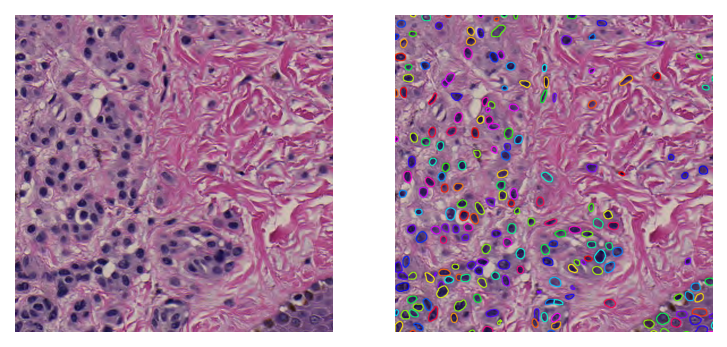

In [9]:
reader = get_wsireader(sample_path)
thumbnail = reader.slide_thumbnail(resolution=0.25, units='mpp')
overlay = visualize_instances_dict(sample, output, line_thickness=2)
thumbnail = thumbnail[:1024, :1024]
overlay = overlay[:1024, :1024]
plt.subplot(1,2,1)
plt.imshow(thumbnail)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.axis('off')
plt.show()

## Tissue Semantic Segmentation

In the same way as `NucleiInstanceSegmentor`, semantic segmentation on WSI and tile can be done in the same way. Here, we illustrate using our pretrained tissue mask segmentation to get the tissue mask for a WSI.

In [2]:
predictor = SemanticSegmentor(
                pretrained_model='fcn-tissue_mask', 
                pretrained_weight='/home/tialab-dang/local/project/tiatoolbox/tests/pretrained/fcn-tissue_mask.pth')

{'pretrained': '/home/tialab-dang/local/project/tiatoolbox/tests/pretrained/pannuke.pth', 'nr_output_ch': 3}


Process Batch: 100%|############################| 23/23 [00:23<00:00,  1.00s/it]


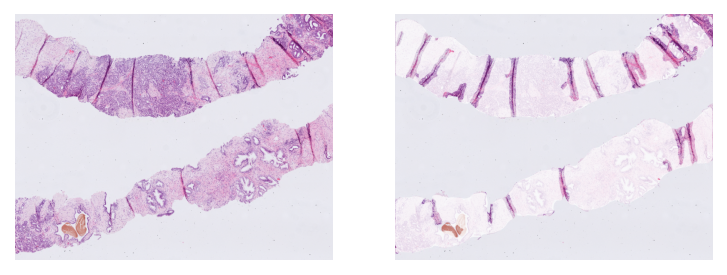

In [6]:
sample_path = '/home/tialab-dang/local/project/tiatoolbox/tests/data/PCA-mini.svs'
output = predictor.predict([sample_path], [None], mode='wsi', 
                        resolution=1.0, units='mpp', on_gpu=True)

reader = get_wsireader(sample_path)
thumbnail = reader.slide_thumbnail(resolution=1.0, units='mpp')

sel = output > 0
alpha = 0.25
colorize_output = (output * 255)[...,None]
overlay = thumbnail.copy()
overlay[sel] = thumbnail[sel] * alpha + (1-alpha) * colorize_output[sel]

plt.subplot(1,2,1)
plt.imshow(thumbnail)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(overlay)
plt.axis('off')
plt.show()

We can see that the model can single out tissue folding artifacts.